In [16]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import timeit

# Array Axis Summation

We want to implement a method to calculate the sum alog an arbitrary axis (row or column) of a given matrix using np.einsum. 

First, let's generate matrices that we can work with. From the script that implements matrix multiplication to see how the time scales (Calculation Time for Matrix Multiplication.ipynb), we have a function that generates even or odd matrices. Here, by even and odd we simply mean that the elements of the matrix are  either all even or all odd. Specifically, for even matrices, the elements are 0, 2, 4, 6, etc... and for odd matrices, the elements are 1, 3, 5, 7, etc... 

 We'll use that function to generate our matrices for consistency. 

In [6]:
#Function to generate even and odd matrices
def generate_matrices(n):
    #Create an array with even numbers from 0 to 2*n^2-2
    E = np.arange(0, 2*n**2, 2).reshape(n, n) #makes an array ranging from 0 to 2n^2 in steps of 2, then reshapes into n rows on length n, making an nxn matrix.
    
    #Create an array with odd numbers from 1 to 2*n**2-1
    O = np.arange(1, 2*n**2 + 1, 2).reshape(n, n)
    
    return E, O

In [12]:
def axis_summation(matrix,row_or_column):
    ''' 
    matrix: The matrix over which you want to do the axis summation
    row_or_column: 0 or 1. The axis over which you want to sum. 1 input sums over rows, 0 input sums over columns.
    '''
    if row_or_column == 1:
        #Sum over rows
        return np.einsum('ij->i', matrix)
    elif row_or_column == 0:
        #Sum over columns
        return np.einsum('ij->j', matrix)
    else:
        raise ValueError("Invalid axis. Use 0 for columns or 1 for rows.")

Now we have our functions. They even make give you an error message if you give an invalid input for summation axis. 

Let's use timeit to time how long this takes.

In [24]:
#Set the maximum matrix size
N = 1500

t_N_rows = []
t_N_columns = []

#Loop through matrix sizes from 1 to N and time their matrix summation
for n in range(1, N):
    E, O = generate_matrices(n)
    
    #Use timeit to time the matrix multiplication
    t_n_rows = timeit.timeit(lambda: axis_summation(E,1), number=50) / 50  # Averaging over 50 runs
    t_n_columns = timeit.timeit(lambda: axis_summation(E,0), number = 50) / 50 
 
    #Append the calculation time to the list
    t_N_rows.append(t_n_rows)
    t_N_columns.append(t_n_columns)

#Convert the matrix sizes and times to numpy arrays
N_values = np.arange(1, N)
t_N_rows = np.array(t_N_rows)
t_N_columns = np.array(t_N_columns)

We'll also set up a fitting function to get useful information about how the time scales. We'll also be able to see if there's any time difference between summing rows and columns.

In [25]:
#Define the fitting function (Power Law: t(N) = A * N^p)
def fit(N, p, A, b):
    return A * N**p+b

#Perform curve fitting for row and column summation
parameters_rows, covariance_rows = opt.curve_fit(fit, N_values, t_N_rows, p0=[4, 10**-5, 0.3], maxfev=10000)
perr_rows = np.sqrt(np.diag(covariance_rows))

parameters_columns, covariance_columns = opt.curve_fit(fit, N_values, t_N_columns, p0=[4, 10**-5, 0.3], maxfev=10000)
perr_columns = np.sqrt(np.diag(covariance_columns))

#Generate fitted values for plotting
fitted_t_N_rows = fit(N_values, *parameters_rows)
fitted_t_N_columns = fit(N_values, *parameters_columns)

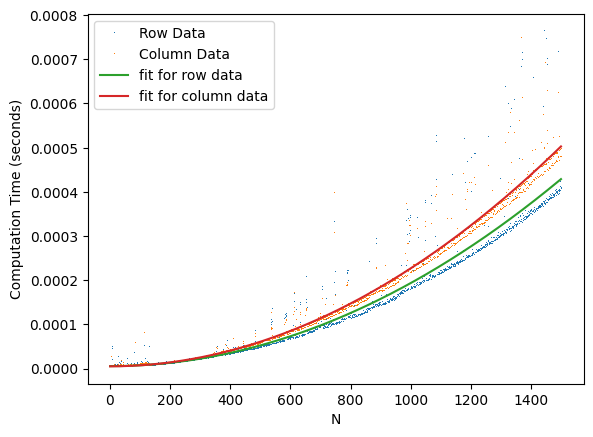

Predicted Fitting Exponent for Row Summation: 2.0037484957448557 ± 0.04422518043601585
Predicted Fitting Exponent for Column Summation: 1.995520294925643 ± 0.021300736282826176


In [26]:
#Plot the original data
plt.plot(N_values, t_N_rows, ',', label='Row Data', markersize=2)
plt.plot(N_values, t_N_columns, ',', label='Column Data', markersize=2)

#Plot the fitted curve
plt.plot(N_values, fitted_t_N_rows, label='fit for row data', zorder=10)
plt.plot(N_values, fitted_t_N_columns, label='fit for column data', zorder=10)
plt.xlabel('N')
plt.ylabel('Computation Time (seconds)')
plt.legend()
plt.show()

#Print the fitting exponent and coefficient
print('Predicted Fitting Exponent for Row Summation: ' + str(parameters_rows[0])+ ' ± ' + str(perr_rows[0]))
print('Predicted Fitting Exponent for Column Summation: ' + str(parameters_columns[0])+ ' ± ' + str(perr_columns[0]))


Finally we see that both row and column summations seem to scale in the same way, but column summations seem to take slightly longer. This might be an artifact of garbage collection and columns being calculated second. 